# AI-PBPK model project: hyperparameters tuning with BayesSearchCV
Author: Kun Mi
Date created: 2025/05/07

Description: In this study, we used ML and Deep nerual network models to predict the require parameter which can be inputed into the PBPK model  


# Install and import required python pacakges

In [ ]:
# Install python pacakges
#!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
!pip install -q lightgbm # install the lightgbm package
!pip install -q scikit-optimize # install the package used for Bayesian optimization
!pip install -q scikeras[tensorflow]
!pip install -q keras-tuner
!pip install -q optuna

In [ ]:
#Install basic python pcakges
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from time import time

# Link to google drive and set up your project folder

In [ ]:
#Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set your working directory to a speicifc folder in your Google Drive
# The base Google Drive directory
root_dir = "/content/drive/My Drive/Colab Notebooks/2-AI-PBPK"

# choose where you want your project files to be saved
project_folder = "/Final model/" # Name your project here. Please instead the "my project folder" to your prefer name

# Make sure that floder exists. If not, automatically create a new folder
if (not os.path.isdir(root_dir + project_folder)):
  os.mkdir(root_dir + project_folder)
  print(root_dir + project_folder + 'did not exist but was created.')

# Change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

Mounted at /content/drive


# Data exploration

In [ ]:
# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "Data-1.csv"))

# Data preprocessing I: missing Values  
Most Machine leanring algorithms canot work with missing features. So, we need to use `SimpleImputer` to replace missing values with median, mean or frequently used values.

In [ ]:
# see how many missing values in your dataset
Data.isna().sum()

,0
Ori,152
ID,0
Type,0
TS,0
MAT,0
Size,46
Zeta,71
Charge,66
Shape,0
TM,0


In [ ]:
# Remove the row with missing data
Data=Data.dropna(subset=['Size','Zeta',"TSz",'Charge']) # you can use 'subset' (e.g., dropna(subset='HD')) to remove the missing value in specific column

In [ ]:
df = pd.DataFrame(Data)

q_high=df["KTRESrelease"].quantile(0.975)
q_low=df["KTRESrelease"].quantile(0.025)
df_filtered=df[(df["KTRESrelease"]<q_high)&(df["KTRESrelease"]>q_low)]

df_X = df_filtered[["Type","TS",'MAT',"Size","Zeta","Shape","TSz","TM","CT",'Charge']]
df_y = df_filtered[["KTRESrelease"]]

In [ ]:
#Define the variable type
cols_num = ['Size','Zeta',"TSz"] #Numerical value
cols_label = ['Type','TS','MAT','Shape','TM','CT']# Label value

# 3. One-hot Encoding



In [ ]:
test_X = df_X

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
cols_label_1hot = ['Type','TS','MAT','Shape','TM','CT','Charge']
data_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(test_X[cols_label_1hot]))
data_cat_1hot.columns = cat_encoder.get_feature_names_out(cols_label_1hot)

print(data_cat_1hot)

     Type_Hybrid  Type_Inorganic  Type_Organic  TS_Active  TS_Passive  \
0            0.0             1.0           0.0        1.0         0.0   
1            0.0             1.0           0.0        1.0         0.0   
2            0.0             1.0           0.0        0.0         1.0   
3            0.0             1.0           0.0        1.0         0.0   
4            0.0             1.0           0.0        0.0         1.0   
..           ...             ...           ...        ...         ...   
397          0.0             1.0           0.0        1.0         0.0   
398          0.0             0.0           1.0        1.0         0.0   
399          0.0             0.0           1.0        1.0         0.0   
400          0.0             0.0           1.0        0.0         1.0   
401          0.0             0.0           1.0        0.0         1.0   

     MAT_Dendrimers  MAT_Gold  MAT_Hybrid  MAT_Hydrogels  MAT_In_Others  ...  \
0               0.0       1.0         0.0  

# 4. Model normalization


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
cols_num = ['Size','Zeta',"TSz"]

mscaler = MinMaxScaler()
Data_num_tr = pd.DataFrame(mscaler.fit_transform(test_X[cols_num]))
Data_num_tr.columns = list(test_X[cols_num].columns)
print(Data_num_tr)

         Size      Zeta       TSz
0    0.086602  0.440698  0.176214
1    0.144777  0.409178  0.036715
2    0.359850  0.433368  0.255823
3    0.381005  0.440698  0.255823
4    0.223667  0.404046  0.255823
..        ...       ...       ...
397  0.147739  0.382788  0.014212
398  0.346188  0.396863  0.018950
399  0.350595  0.398475  0.018950
400  0.038123  0.475150  0.018950
401  0.366681  0.351268  0.013028

[402 rows x 3 columns]


# Compile data

In [ ]:
preData=pd.concat([Data_num_tr,data_cat_1hot], axis=1)
print(preData)

         Size      Zeta       TSz  Type_Hybrid  Type_Inorganic  Type_Organic  \
0    0.086602  0.440698  0.176214          0.0             1.0           0.0   
1    0.144777  0.409178  0.036715          0.0             1.0           0.0   
2    0.359850  0.433368  0.255823          0.0             1.0           0.0   
3    0.381005  0.440698  0.255823          0.0             1.0           0.0   
4    0.223667  0.404046  0.255823          0.0             1.0           0.0   
..        ...       ...       ...          ...             ...           ...   
397  0.147739  0.382788  0.014212          0.0             1.0           0.0   
398  0.346188  0.396863  0.018950          0.0             0.0           1.0   
399  0.350595  0.398475  0.018950          0.0             0.0           1.0   
400  0.038123  0.475150  0.018950          0.0             0.0           1.0   
401  0.366681  0.351268  0.013028          0.0             0.0           1.0   

     TS_Active  TS_Passive  MAT_Dendrim

# Define X and y

In [ ]:
y_re = df_y
X_re = preData

# LightGbm model with pretest

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size = 0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(321, 42) (81, 42) (321, 1) (81, 1)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVC,SVR
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.kernel_ridge import KernelRidge

### Evaluate function

In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):

    print(f"\n=== Evaluation for: {model_name} ===")

    # Define KFold for cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validation scores
    cv_r2 = cross_val_score(model, X_train, y_train, cv=cv, scoring="r2")
    cv_rmse = -cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

    # Fit model before test prediction
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Output
    print("\nTest Set Performance:")
    print(f"R2 Score : {test_r2:.3f}")
    print(f"RMSE     : {test_rmse:.3f}")

    print("\nCross-Validation Performance:")
    print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
    print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")


###Kernel Ridge

In [ ]:
import optuna
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#KernelRidge
def objective(trial):
    param = {
    "kernel": trial.suggest_categorical("kernel", ["rbf"]),
    "alpha": trial.suggest_loguniform("alpha", 1e-3, 1e0),
    "gamma": trial.suggest_loguniform("gamma", 1e-4, 1e-1),
    }

    model = KernelRidge(**param)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    Score = r2_score(y_test, preds)

    return Score


# Optimization
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

# Output
print("Best parameters:", study.best_params)
print(f"Best R² score: {study.best_value:.4f}")

Best parameters: {'kernel': 'rbf', 'alpha': 0.03460022274398778, 'gamma': 0.0008562855373173892}
Best R² score: 0.0226


In [ ]:
### Develop the best model
best_params = study.best_params
KRR = KernelRidge(**best_params)

KRR.fit(X_train, y_train)

train_preds = KRR.predict(X_train)
test_preds = KRR.predict(X_test)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# Predict on the test set
# Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=8)

# Cross-validation scores
cv_r2 = cross_val_score(KRR, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(KRR, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")

Trian set r2 0.16017570527932812
Trian set RMSE 1.6318356992189589
---------------------------------------------------------------------
Test set r2 0.022568482510139765
Test set RMSE 1.86515053461355

Cross-Validation Performance:
R2 Score : 0.084 ± 0.044
RMSE     : 1.692 ± 0.241


###Random forest

In [ ]:
import optuna
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#Random forest model
def objective(trial):
    param = {"n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])}

    model = RandomForestRegressor(**param)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring="r2", cv=cv, n_jobs=-1)


    return scores.mean()

# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 100)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)


Best parameters: {'n_estimators': 168, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}
Best r2 score: 0.04188033553670083


In [ ]:
### Develop the best model
best_params = study.best_params
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)

train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_r2 = cross_val_score(rf, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(rf, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")

Trian set r2 0.47498401567720505
Trian set RMSE 1.2902339812000594
---------------------------------------------------------------------
Test set r2 0.08001863708601298
Test set RMSE 1.8095068620159818

Cross-Validation Performance:
R2 Score : 0.032 ± 0.095
RMSE     : 1.674 ± 0.365


###XGBoost

In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#XGboost
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.2),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0)
    }

    model = XGBRegressor(**param, random_state=42)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring="r2", cv=cv)

    return scores.mean()


# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 100)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)

Best parameters: {'n_estimators': 369, 'max_depth': 8, 'learning_rate': 0.0022332628302492866, 'colsample_bytree': 0.6460075140565683, 'gamma': 0.5269095298348951, 'reg_alpha': 0.06094838344227187, 'reg_lambda': 6.865502675856965}
Best r2 score: 0.027195096015930176


In [ ]:
### Develop the best model
best_params = study.best_params
XGB= XGBRegressor(**best_params, random_state=42)
XGB.fit(X_train, y_train)

train_preds = XGB.predict(X_train)
test_preds = XGB.predict(X_test)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_r2 = cross_val_score(XGB, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(XGB, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")

Trian set r2 0.3497704267501831
Trian set RMSE 1.4358714818954468
---------------------------------------------------------------------
Test set r2 0.07523930072784424
Test set RMSE 1.8142008781433105

Cross-Validation Performance:
R2 Score : 0.027 ± 0.011
RMSE     : 1.686 ± 0.404


### SVM

In [ ]:
import optuna
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#XGboost
def objective(trial):
    param = {
        "C": trial.suggest_loguniform("C", 1e-2, 1e3),
        "epsilon": trial.suggest_uniform("epsilon", 0.01, 1.0),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
        "degree": trial.suggest_int("degree", 2, 5),
        "gamma": trial.suggest_loguniform("gamma", 1e-4, 1.0),
        "coef0": trial.suggest_uniform("coef0", 0.0, 1.0)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    Score = r2_score(y_test, preds)
    return Score


# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)

Best parameters: {'C': 3.6441293763600235, 'epsilon': 0.9633649704260439, 'kernel': 'linear', 'degree': 3, 'gamma': 0.0029426477761034277, 'coef0': 0.7973917526901669}
Best r2 score: 0.06055650810225022


In [ ]:
### Develop the best model
from sklearn.svm import SVR

best_params = study.best_params
SVR= SVR(**best_params)
SVR.fit(X_train, y_train)

train_preds = SVR.predict(X_train)
test_preds = SVR.predict(X_test)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_r2 = cross_val_score(SVR, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(SVR, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")

Trian set r2 0.13017223851018278
Trian set RMSE 1.6607292893882073
---------------------------------------------------------------------
Test set r2 0.06055650810225022
Test set RMSE 1.8285466759482012

Cross-Validation Performance:
R2 Score : 0.019 ± 0.057
RMSE     : 1.689 ± 0.395


# Deep nerual network model with keras

In [ ]:
# import basic packages
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import scikeras
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl
import optuna
# import keras related packages
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import Objective
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Sequential
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, root_mean_squared_error
from tensorflow.keras.layers import BatchNormalization

In [ ]:
X = X_re.to_numpy()
y = y_re.to_numpy()
# summarize shape
print(X.shape, y.shape)

(402, 42) (402, 1)


In [ ]:
from sklearn.model_selection import train_test_split#18

seed=18

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.125, random_state=22)
print(X_temp.shape, X_test.shape, y_temp.shape, y_test.shape)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(321, 42) (81, 42) (321, 1) (81, 1)
(280, 42) (41, 42) (280, 1) (41, 1)


# Tuning Model with Keras Tuner

In [ ]:
!pip install -q optuna-integration[tfkeras]

In [ ]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from optuna.integration import TFKerasPruningCallback
import tempfile

def objective(trial):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Input
    dense_bot = trial.suggest_int('dense_bot', 32, 512, step=32)
    activation = trial.suggest_categorical('dense_activation', ['relu', 'tanh', 'sigmoid'])
    model.add(Dense(dense_bot))
    # model.add(BatchNormalization())
    model.add(Activation(activation))

    # Hidden
    num_layers = trial.suggest_int('num_dense_layers', 1, 4)
    for i in range(num_layers):
        units = trial.suggest_int(f'dense_{i}', 64, 1024, step=64)
        act = trial.suggest_categorical(f'act_{i}', ['relu', 'tanh', 'sigmoid'])
        dropout = trial.suggest_float(f'dropout_{i}', 0.0, 0.6, step=0.2)

        model.add(Dense(units))
        # model.add(BatchNormalization())
        model.add(Activation(act))
        model.add(Dropout(dropout))

    # Output
    model.add(Dense(1, activation='linear'))

    # Optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Nadam'])
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-2, log=True)
    optimizer = tf.keras.optimizers.get({'class_name': optimizer_name, 'config': {'learning_rate': lr}})

    model.compile(optimizer=optimizer,
           loss= MeanSquaredError())

    # Model train
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=16,
        epochs=128,
        verbose=0,
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            TFKerasPruningCallback(trial, "val_loss")
        ]
    )

    # Evaluiation
    y_pred= model.predict(X_test, verbose=0)
    r2 = r2_score(y_test, y_pred)

    # Model save
    model_path = tempfile.NamedTemporaryFile(delete=False, suffix=".keras").name
    model.save(model_path)
    trial.set_user_attr("model_path", model_path)

    return r2



In [ ]:
from optuna.pruners import MedianPruner

study = optuna.create_study(
    direction='maximize',
    pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=16)
)
study.optimize(objective, n_trials=100)

[I 2025-07-09 19:11:00,520] A new study created in memory with name: no-name-5ac930f3-b5de-4919-8398-319179ac91b3
[I 2025-07-09 19:11:28,683] Trial 0 finished with value: 0.09188882812517851 and parameters: {'dense_bot': 160, 'dense_activation': 'relu', 'num_dense_layers': 3, 'dense_0': 832, 'act_0': 'relu', 'dropout_0': 0.6, 'dense_1': 256, 'act_1': 'sigmoid', 'dropout_1': 0.4, 'dense_2': 256, 'act_2': 'relu', 'dropout_2': 0.6, 'optimizer': 'Adam', 'learning_rate': 0.00013647690094310456}. Best is trial 0 with value: 0.09188882812517851.
[I 2025-07-09 19:11:41,522] Trial 1 finished with value: -0.001162652303778433 and parameters: {'dense_bot': 480, 'dense_activation': 'sigmoid', 'num_dense_layers': 4, 'dense_0': 256, 'act_0': 'relu', 'dropout_0': 0.4, 'dense_1': 832, 'act_1': 'tanh', 'dropout_1': 0.0, 'dense_2': 896, 'act_2': 'tanh', 'dropout_2': 0.6, 'dense_3': 448, 'act_3': 'sigmoid', 'dropout_3': 0.4, 'optimizer': 'Nadam', 'learning_rate': 1.7773243369084346e-05}. Best is trial 0 

In [ ]:
# Load model
best_model_path = study.best_trial.user_attrs["model_path"]
best_model = tf.keras.models.load_model(best_model_path)

# Model prediction
print("Best train R²:",r2_score(y_temp, best_model.predict(X_temp)))
print("Best train rmse:",root_mean_squared_error(y_temp, best_model.predict(X_temp)))
print("Best test R²:",r2_score(y_test, best_model.predict(X_test)))
print("Best test rmse:",root_mean_squared_error(y_test, best_model.predict(X_test)))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best train R²: 0.5846197765202399
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Best train rmse: 1.1716176017622588
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Best test R²: 0.30386156010746757
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Best test rmse: 1.4557823314911662


In [ ]:

def build_best_model(params):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Input Layer
    model.add(Dense(params['dense_bot']))
    # model.add(BatchNormalization())
    model.add(Activation(params['dense_activation']))

    # Hidden Layers
    for i in range(params['num_dense_layers']):
        model.add(Dense(params[f'dense_{i}']))
        # model.add(BatchNormalization())
        model.add(Activation(params[f'act_{i}']))
        model.add(Dropout(params[f'dropout_{i}']))

    # Output Layer
    model.add(Dense(1, activation='linear'))

    # Optimizer
    if params['optimizer'] == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    elif params['optimizer'] == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=params['learning_rate'])

    # Compile
    model.compile(optimizer=optimizer, loss= 'mse', metrics=['mae', 'mse'])
    return model

In [ ]:
params = study.best_trial.params
model = build_best_model(params)

In [ ]:
# save model and architecture to single file
best_model.save("KTRESrel_0611-9.keras")##7 and 8 seed 18 22
print("Saved model to disk")

Saved model to disk


In [ ]:
load_model= keras.models.load_model("KTRESrel_0515-5.keras")

In [ ]:
best_model= keras.models.load_model("KTRESrel_0515-5.keras")

early_stop = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
best_model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stop], epochs=512, batch_size=32, verbose=0)

print("Best train R²:",r2_score(y_temp, best_model.predict(X_temp)))
print("Best train rmse:",root_mean_squared_error(y_temp, best_model.predict(X_temp)))
print("Best test R²:",r2_score(y_test, best_model.predict(X_test)))
print("Best test rmse:",root_mean_squared_error(y_test, best_model.predict(X_test)))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Best train R²: 0.4474410127785754
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Best train rmse: 1.3513016384180874
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Best test R²: 0.6218569236535599
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Best test rmse: 1.0729431534859504


# Display the R-squared value on scatterplot with regression model

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


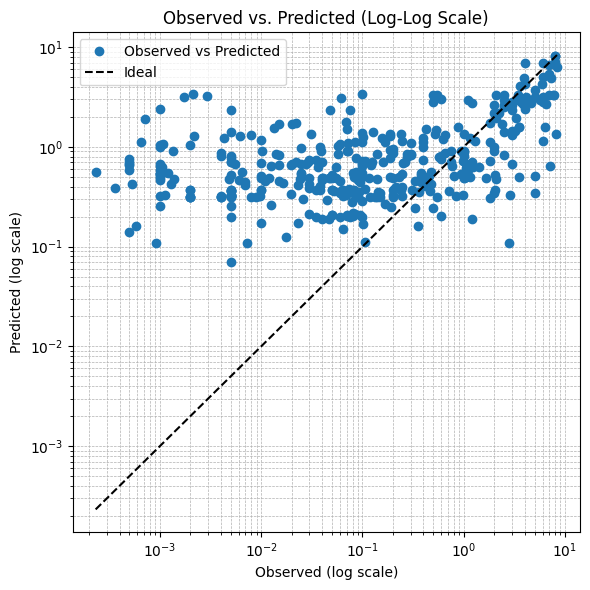

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Model prediction
y_obs = y_re
all_preds = best_model.predict(X_re)

# # Transfer numpy
y_obs = np.ravel(y_obs)
all_preds = np.ravel(all_preds)

#  Plot
plt.figure(figsize=(6, 6))
plt.plot(y_obs, all_preds, 'o', label='Observed vs Predicted')

# linear regression line
log_y_obs = np.log10(y_obs )
log_y_pred = np.log10(all_preds)
m, b = np.polyfit(log_y_obs, log_y_pred, 1)

# y = x
plt.plot([y_obs.min(), y_obs.max()], [y_obs.min(), y_obs.max()], 'k--', label='Ideal')

#
plt.xscale("log")
plt.yscale("log")

# Label
plt.xlabel("Observed (log scale)")
plt.ylabel("Predicted (log scale)")
plt.title("Observed vs. Predicted (Log-Log Scale)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
PredKmax = pd.concat([pd.DataFrame(df_filtered["ID"].reset_index(drop=True)), pd.DataFrame(y_obs), pd.DataFrame(all_preds)], axis = 1)
PredKmax.columns = ["ID","Obs_KTRESrelease", "KTRESrelease"]
PredKmax.to_csv('KTRESrelease.csv', encoding = 'utf-8-sig',index=False)

# K-fold cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow.keras as keras

dnn_base_model = keras.models.load_model("KTRESrel_0515-5.keras")

kfold = KFold(n_splits=5, shuffle=True, random_state=18)
cvr2scores = []
cvrmsescores = []

for fold, (train_ix, test_ix) in enumerate(kfold.split(X_temp), 1):
    X_train_n, X_test_n = X_temp[train_ix], X_temp[test_ix]
    y_train_n, y_test_n = y_temp[train_ix], y_temp[test_ix]

    dnn_model = clone_model(dnn_base_model)
    dnn_model.set_weights(dnn_base_model.get_weights())
    dnn_model.compile(optimizer='Nadam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
    dnn_model.fit(X_train_n, y_train_n, validation_data=(X_test_n, y_test_n), callbacks=[early_stop],
                  epochs=500, batch_size=32, verbose=0)

    # Fittnees
    test_pred = dnn_model.predict(X_test_n).flatten()
    r2score = r2_score(y_test_n, test_pred)
    rmse = root_mean_squared_error(y_test_n, test_pred)

    print(f"[Fold {fold}] R²: {r2score:.3f}, RMSE: {rmse:.3f}")

    cvr2scores.append(r2score)
    cvrmsescores.append(rmse)

# Output
print("\n=== Cross-validation summary ===")
print("The 5-CV R² Score was: %.2f (+/- %.2f)" % (np.mean(cvr2scores), np.std(cvr2scores)))
print("The 5-CV RMSE Score was: %.2f (+/- %.2f)" % (np.mean(cvrmsescores), np.std(cvrmsescores)))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
[Fold 1] R²: 0.312, RMSE: 1.559
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step 
[Fold 2] R²: 0.606, RMSE: 1.125


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
[Fold 3] R²: 0.075, RMSE: 1.198


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
[Fold 4] R²: 0.394, RMSE: 1.016
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 
[Fold 5] R²: 0.285, RMSE: 2.073

=== Cross-validation summary ===
The 5-CV R² Score was: 0.33 (+/- 0.17)
The 5-CV RMSE Score was: 1.39 (+/- 0.39)


# Save predicted values (to csv file)

In [ ]:
PredKmax = pd.concat([pd.DataFrame(Data.dropna()["ID"].reset_index(drop=True)), pd.DataFrame(y_obs), pd.DataFrame(all_preds)], axis = 1)
PredKmax.columns = ["ID","KTRESrelease", "Pred_KTRESrelease"]
PredKmax.to_csv('output_KTRESrelease.csv', encoding = 'utf-8-sig',index=False)